In [18]:
import pandas as pd
import copy
import numpy as np
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

full_palette = custom_colors + complementary_colors
sns.set_palette(full_palette)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [20]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv1.pkl')
df['id'] = df['id'].astype(str)
df

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,label_stress_sema,negative_affect_category,stai_stress_category
0,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,175.0,1130.0,9.0,0.0,<30,MALE,21.0,NaN,Average,Average
1,621e30e467b776a240e817c7,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.0,703.0,64.0,2.0,<30,MALE,>=30,1.0,Average,Average
2,621e367e67b776a24087d75d,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,120.0,1319.0,0.0,0.0,NaN,MALE,NaN,NaN,Average,Average
3,621e360b67b776a24039709f,2021-05-24,NaN,68.321,31.413,NaN,15.4,69.0,0.633333,0.65,...,127.0,1306.0,7.0,0.0,>=30,FEMALE,<19,NaN,Average,Average
4,621e2f6167b776a240e082a9,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,82.0,1306.0,2.0,0.0,>=30,FEMALE,>=25,NaN,Average,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,621e300767b776a2404dc717,2022-01-17,33.186399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,1380.0,4.0,0.0,<30,MALE,29.0,NaN,Average,Average
4905,621e309b67b776a240b532b0,2022-01-17,31.815133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,129.0,1208.0,6.0,0.0,>=30,MALE,23.0,NaN,Average,Average
4906,621e342e67b776a2404ce460,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,7.0,0.0,0.0,<30,MALE,29.0,NaN,Average,Average
4907,621e309267b776a240ae1cdb,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<30,MALE,<19,NaN,Average,Average


In [21]:
df.columns

Index(['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'badgeType', 'calories',
       'filteredDemographicVO2Max', 'distance', 'activityType', 'bpm',
       'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'label_stress_sema', 'negative_affect_category',
       'stai_stress_category'],
    

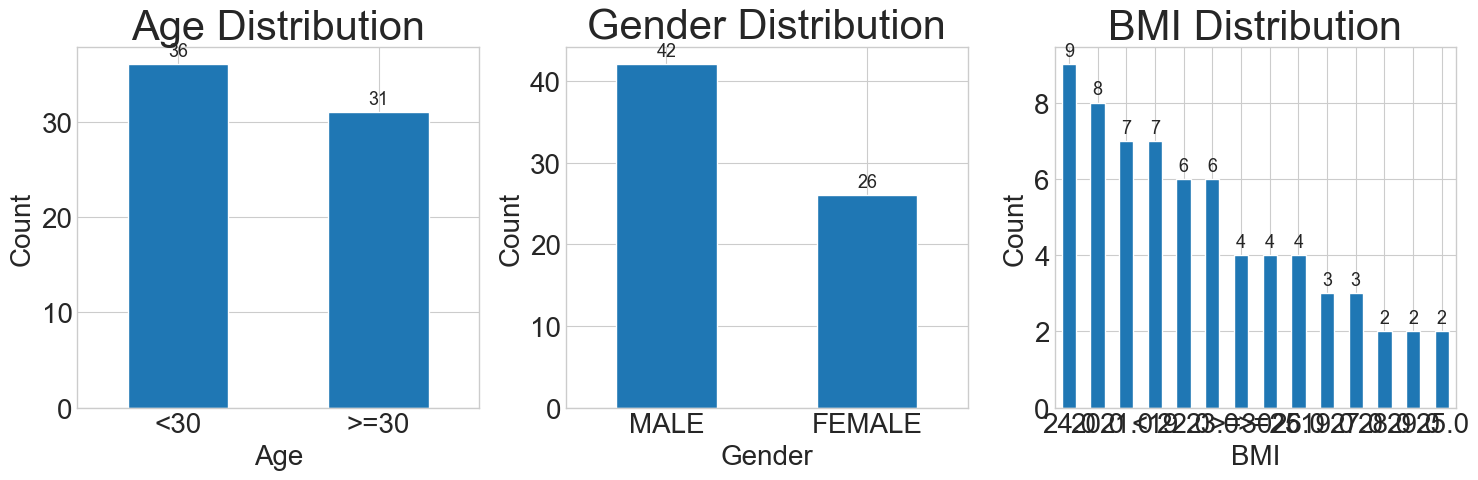

In [22]:
unique_users = df.drop_duplicates(subset='id')

# Counting unique occurrences for age, gender, and BMI
age_counts = unique_users['age'].value_counts()
gender_counts = unique_users['gender'].value_counts()
bmi_counts = unique_users['bmi'].value_counts()


plt.figure(figsize=(15, 5))

# Function to add labels on top of each bar
def add_labels(ax):
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Age Plot
ax1 = plt.subplot(1, 3, 1)
age_counts.plot(kind='bar', ax=ax1)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)
add_labels(ax1)

# Gender Plot
ax2 = plt.subplot(1, 3, 2)
gender_counts.plot(kind='bar', ax=ax2)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
add_labels(ax2)

# BMI Plot
ax3 = plt.subplot(1, 3, 3)
bmi_counts.plot(kind='bar', ax=ax3)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.xticks(rotation=0)
add_labels(ax3)

plt.tight_layout()
plt.savefig("../visualizations/lifesnaps/demographics_barplots.png",bbox_inches='tight')
plt.savefig("../visualizations/lifesnaps/demographics_barplots.eps",bbox_inches='tight')
plt.show()

In [23]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    
    plt.savefig("../visualizations/lifesnaps/%s_distribution.png"%y_var,bbox_inches='tight')
    plt.savefig("../visualizations/lifesnaps/%s_distribution.eps"%y_var,bbox_inches='tight')

    plt.show()

C:\Users\ChristinaKaragianni\AppData\Local\Temp\ipykernel_11104\1912276430.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


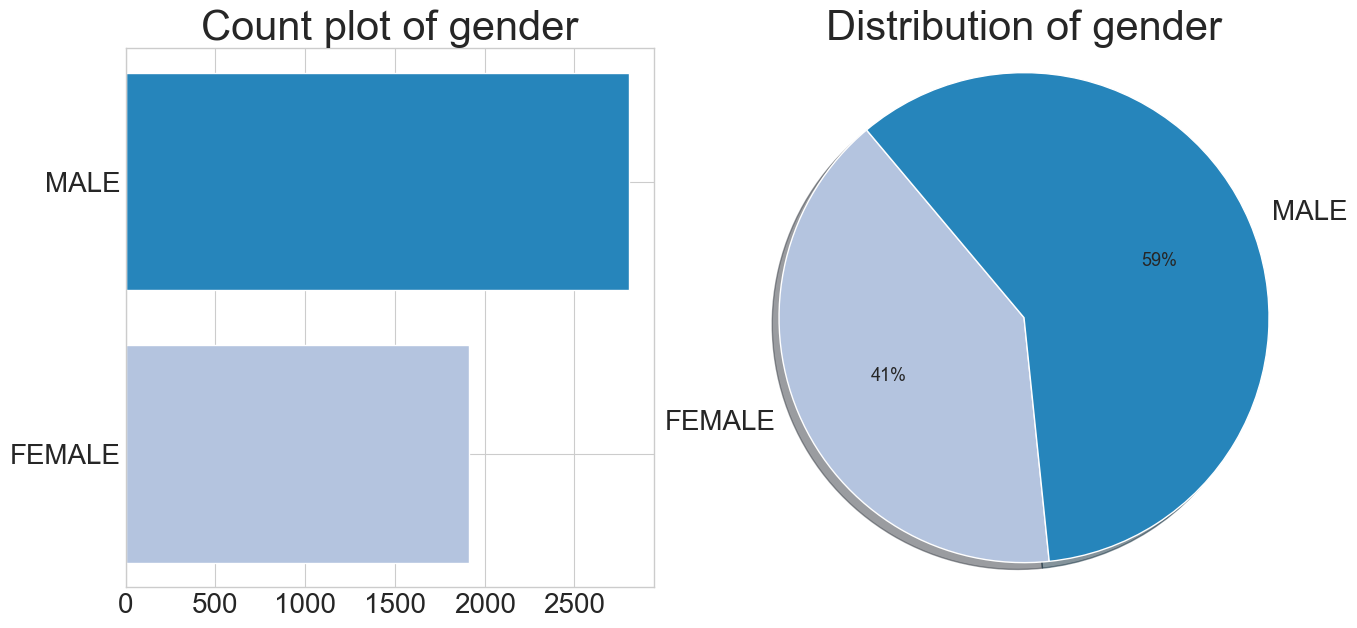

In [24]:
var = 'gender'
target_distribution(y_var=var, data=df)

C:\Users\ChristinaKaragianni\AppData\Local\Temp\ipykernel_11104\1912276430.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


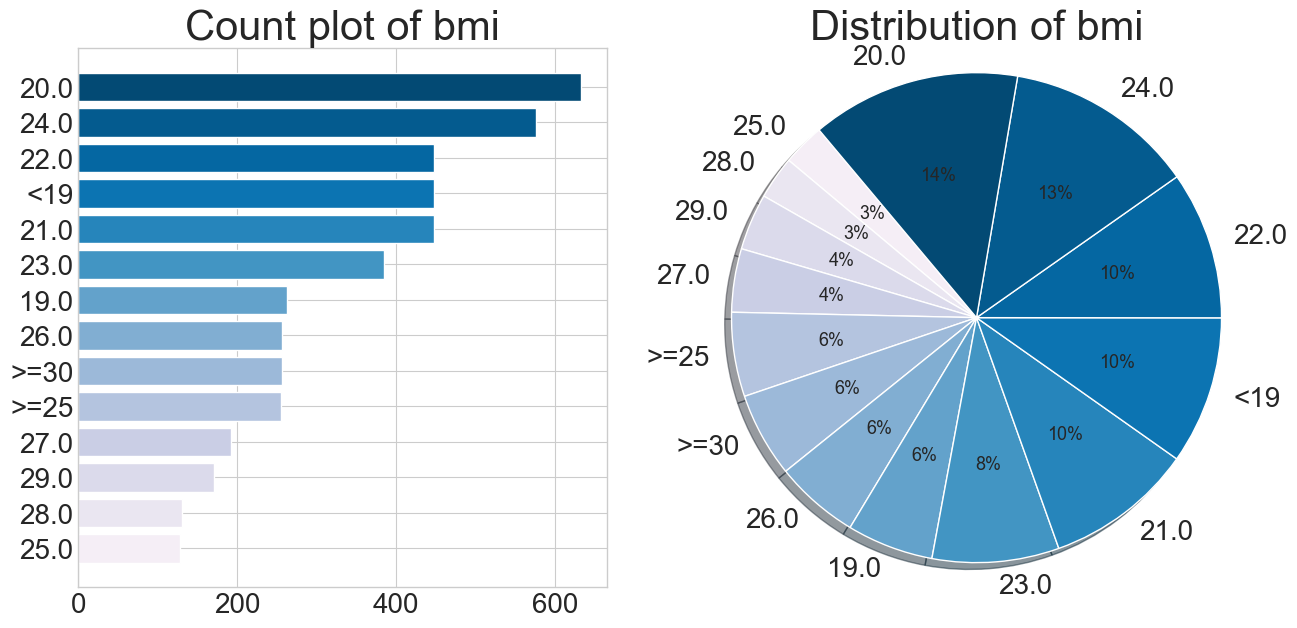

In [25]:
var = 'bmi'
target_distribution(y_var=var, data=df)

C:\Users\ChristinaKaragianni\AppData\Local\Temp\ipykernel_11104\1912276430.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


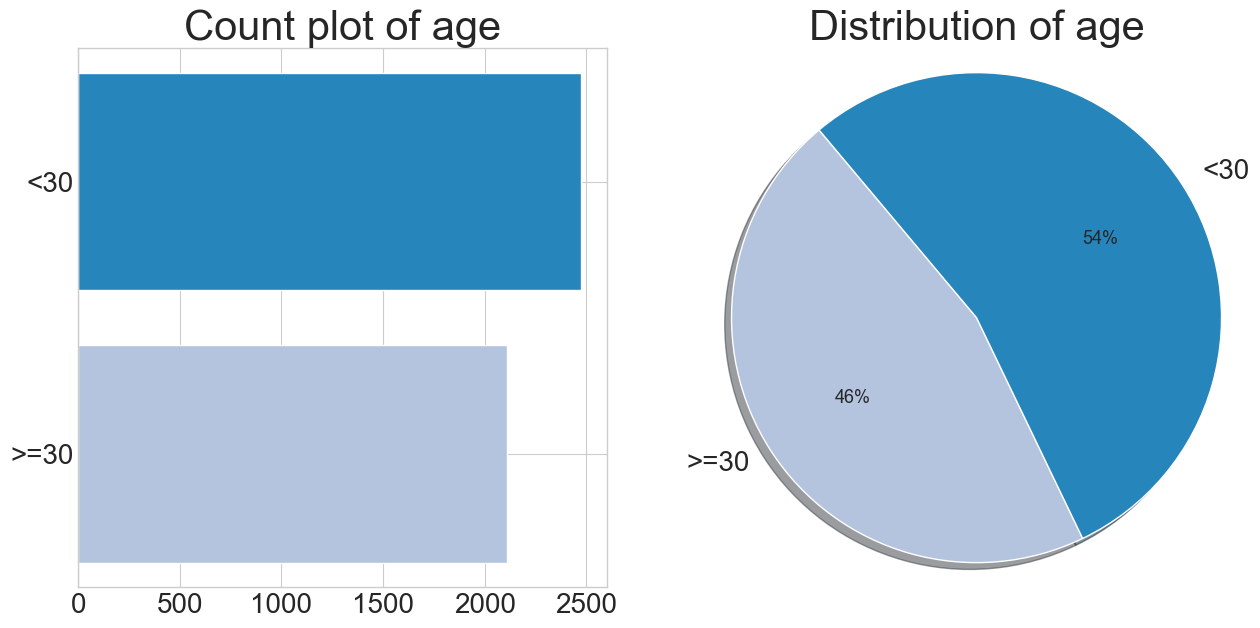

In [26]:
var = 'age'
target_distribution(y_var=var, data=df)

In [27]:
# frequency distribution of combinations of gender, age, and bmi categories within the dataset

freq_target = df.groupby(['gender', 'age', 'bmi']).size()
freq_target = freq_target / len(df)
freq_target = freq_target.reset_index(name='Frequency')
freq_target = freq_target.sort_values(by='Frequency', ascending=False) # Sort by frequency in descending order
freq_target

,gender,age,bmi,Frequency
1,FEMALE,<30,20.0,0.063964
16,MALE,<30,21.0,0.052353
27,MALE,>=30,24.0,0.052149
3,FEMALE,<30,23.0,0.039112
29,MALE,>=30,26.0,0.039112
26,MALE,>=30,23.0,0.039112
18,MALE,<30,24.0,0.039112
10,FEMALE,>=30,22.0,0.039112
12,FEMALE,>=30,<19,0.039112
8,FEMALE,>=30,20.0,0.038908


In [28]:
# DataFrame values must be numerical
df['age'].replace(to_replace=['<30', '>=30'], value=[0, 1], inplace=True)
df['gender'].replace(to_replace=['MALE', 'FEMALE'], value=[0, 1], inplace=True)
df['bmi'].replace(to_replace=['Underweight', 'Normal', 'Overweight', 'Obese'], value=[0, 1, 2, 3], inplace=True)

In [30]:
protected_attributes = ['gender', 'bmi', 'age']
privileged_classes = [[0, 1, 0]]
data = StandardDataset(df,  label_name='negative_affect_category', favorable_classes=[0], protected_attribute_names=protected_attributes, privileged_classes=privileged_classes, features_to_drop=['id', 'date'])
metric = BinaryLabelDatasetMetric(data, unprivileged_groups=[{'gender': 1, 'bmi': 0, 'age': 1}], privileged_groups=[{'gender': 0, 'bmi': 1, 'age': 0}])

print("Consistency:", metric.consistency()) # Measures how consistently similar individuals receive similar predictions, regardless of their group. Higher consistency indicates less potential discrimination. Individual fairness metric from [1] that measures how similar the labels are for similar instances. 
# [1] (1, 2) R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork, “Learning Fair Representations,” International Conference on Machine Learning, 2013.

NotImplementedError: 

In [32]:
data = StandardDataset(df, label_name='label_stress_sema', favorable_classes=[0],
                       protected_attribute_names=protected_attributes, 
                       privileged_classes=privileged_classes,
                       features_to_drop=['id', 'date'])

# DataFrame to store the results
bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'consistency'])

# Loop through each protected attribute to calculate consistency
for attr in data.protected_attribute_names:
    print("\nEvaluating Consistency for {}".format(attr))

    # Calculate consistency metric
    consistency_metric = BinaryLabelDatasetMetric(data).consistency()

    # Updating DataFrame
    bias_columns_metric.loc[len(bias_columns_metric.index)] = [attr, consistency_metric[0]]
    print("Fairness Evaluation - Consistency: {}".format(consistency_metric[0]))

NotImplementedError: 